In [1]:
import cv2
import numpy as np
from torch.nn import Linear, Softmax, CrossEntropyLoss, ReLU
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger, CometLogger
from pytorch_lightning import LightningModule
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import os
from PIL import Image
from tqdm.auto import tqdm
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights


def _doc_anh_va_video(input_folder: str, output_folder: str):
    os.makedirs(output_folder, exist_ok=True)
    img_classes = ['live', 'PC_Replay', 'Print_Attacks_Samples',
                   'cutout', 'mask3d', 'monitor', 'outline3d', 'outline', 'mask']
    img_class = ""
    files = [os.path.join(root, file) for root, dirs,
             files in os.walk(input_folder) for file in files]
    for file in tqdm(files, desc="Processing"):
        if os.path.basename(file).lower().endswith(('.jpg', '.jpeg', '.png')):
            img = cv2.imread(filename=file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if img is None:
                continue
            cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            for ele in img_classes:
                if ele in file:
                    img_class = ele
                    break

            subfolder_path = os.path.join(output_folder, img_class)
            os.makedirs(subfolder_path, exist_ok=True)
            cv2.imwrite(os.path.join(subfolder_path,
                        f"{os.path.basename(file)}.jpg"), img=img)
        elif os.path.basename(file).lower().endswith(('.mov', '.mp4', '.avi')):
            cap = cv2.VideoCapture(file)
            if not cap.isOpened():
                continue
            total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            for ele in img_classes:
                if ele in file:
                    img_class = ele
                    break
            subfolder_path = os.path.join(output_folder, img_class)
            os.makedirs(subfolder_path, exist_ok=True)
            for i, ele in enumerate([0.25, 0.5, 0.75]):
                cap.set(cv2.CAP_PROP_POS_FRAMES, int(total_frame * ele))
                flag, frame = cap.read()
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                if flag:
                    cv2.imwrite(os.path.join(
                        subfolder_path, f"{os.path.basename(file)}_{i}.jpg"), img=frame)
            cap.release()   

# _doc_anh_va_video(
#     "/kaggle/input/haui-aio/publics_data_train/publics_data_train", 'data')

In [ ]:
from torchvision.datasets import ImageFolder

class CustomImageFolder(ImageFolder):
    def __init__(self, root, classes_order=None, **kwargs):
        super().__init__(root, **kwargs)
        if classes_order is not None:
            self.class_to_idx = {cls: i for i, cls in enumerate(classes_order)}
            self.classes = classes_order

# Ví dụ
dataset = CustomImageFolder(
    root="data/train",
    classes_order=['cat', 'dog', 'bird']
)


In [2]:
!ls data

cutout	mask	monitor  outline3d  Print_Attacks_Samples
live	mask3d	outline  PC_Replay


In [3]:
for ele in ['live', 'PC_Replay', 'Print_Attacks_Samples', 'cutout', 'mask3d', 'monitor', 'outline3d', 'outline', 'mask']:
    print(ele, len(os.listdir(f'data/{ele}')))

live 763
PC_Replay 90
Print_Attacks_Samples 225
cutout 159
mask3d 279
monitor 198
outline3d 216
outline 177
mask 1566


In [4]:
import os
import numpy as np
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from torchvision.datasets import ImageFolder
from torchvision.models import EfficientNet_B3_Weights
from pytorch_lightning import seed_everything

# reproducibility
seed_everything(42, workers=True)

# Load dataset + transform
transforms = EfficientNet_B3_Weights.IMAGENET1K_V1.transforms()
dataset = ImageFolder('data', transforms)

# Thông tin class
img_classes = dataset.classes
class_counts = [len(os.listdir(f"data/{cls}")) for cls in img_classes]
class_weights = 1.0 / np.array(class_counts)

# Split dataset
n = len(dataset)
train_size = int(n * 0.9)
val_size = n - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Tạo sampler cho train set
train_targets = [dataset.samples[i][1] for i in train_dataset.indices]
print(train_targets)
sample_weights = [class_weights[t] for t in train_targets]
print(sample_weights)
train_sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_targets), replacement=True)

# Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=3)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=3)


[6, 3, 3, 1, 3, 4, 4, 4, 3, 4, 5, 3, 5, 3, 4, 3, 2, 8, 4, 3, 8, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 5, 4, 3, 4, 7, 3, 4, 7, 4, 4, 5, 3, 6, 4, 8, 4, 3, 5, 4, 2, 4, 8, 4, 3, 3, 5, 4, 4, 3, 1, 4, 4, 1, 4, 4, 2, 1, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 1, 7, 3, 4, 3, 6, 5, 3, 7, 4, 4, 3, 5, 8, 4, 7, 4, 4, 4, 3, 8, 5, 7, 4, 4, 4, 4, 3, 7, 4, 4, 2, 4, 7, 8, 3, 4, 4, 5, 3, 0, 3, 3, 3, 4, 4, 1, 1, 4, 8, 4, 2, 5, 4, 1, 4, 4, 4, 4, 4, 4, 7, 3, 5, 4, 4, 4, 4, 7, 4, 4, 5, 1, 6, 6, 2, 7, 2, 4, 1, 4, 4, 4, 4, 4, 4, 8, 7, 5, 4, 4, 4, 8, 4, 4, 4, 2, 4, 4, 5, 4, 3, 3, 1, 4, 3, 4, 6, 8, 4, 3, 4, 7, 3, 3, 5, 4, 8, 7, 4, 1, 4, 3, 4, 2, 8, 4, 4, 4, 5, 3, 1, 8, 0, 4, 1, 5, 3, 4, 0, 2, 4, 3, 3, 4, 8, 4, 3, 1, 3, 4, 4, 3, 4, 8, 4, 4, 4, 7, 7, 4, 4, 4, 7, 8, 5, 3, 3, 4, 6, 7, 3, 3, 2, 4, 4, 8, 4, 3, 3, 5, 7, 4, 4, 6, 3, 4, 7, 4, 4, 5, 4, 3, 8, 5, 6, 4, 7, 3, 0, 4, 4, 4, 2, 3, 6, 4, 2, 4, 4, 0, 4, 3, 4, 8, 4, 3, 1, 1, 4, 1, 8, 6, 3, 4, 3, 4, 3, 6, 1, 2, 4, 3, 3, 7, 6, 4, 1, 4, 3, 3, 4, 3, 4, 1, 3, 3, 4, 3, 4, 4, 7, 4, 4, 

In [5]:
print(efficientnet_b3(weights=None))

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [10]:
from functools import cache
from torch.nn import Sequential
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

@cache
def _get_model():
    model = efficientnet_b3()
    model.classifier[1] = Sequential(
        Linear(in_features=model.classifier[1].in_features, out_features=len(
            img_classes), bias=True)
    )
    return model


class WrapperModel(LightningModule):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.model = _get_model()
        self.val_predicts = []
        self.val_targets = []
        class_weights = 1.0 / torch.tensor([len(os.listdir(f"data/{cls}")) for cls in img_classes], dtype=torch.float)
        self.criterion = CrossEntropyLoss(
            weight=class_weights)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('Train loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('Val loss', loss, prog_bar=True)
        self.val_predicts.append(y_hat.detach().cpu())
        self.val_targets.append(y.detach().cpu())
        return loss

    def on_validation_epoch_end(self):
        all_preds = torch.cat(self.val_predicts)
        all_targets = torch.cat(self.val_targets)

        report = classification_report(
            all_targets, np.argmax(all_preds.numpy(), axis=1), output_dict=True, zero_division=0
        )

        self.log("Accuracy", report['accuracy'], prog_bar=True)
        self.log("Precision", report['weighted avg']
                 ['precision'], prog_bar=True)
        self.log("Recall", report['weighted avg']['recall'], prog_bar=True)
        self.log("F1 score", report['weighted avg']['f1-score'], prog_bar=True)
        cm = confusion_matrix(all_targets, np.argmax(all_preds.numpy(), axis=1))
        fig, ax = plt.subplots(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=dataset.classes, yticklabels=dataset.classes)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_title(f'confusion_matrix at epoch {self.current_epoch}')
        self.logger.experiment.add_figure("confusion_matrix", fig, self.current_epoch)
        plt.close(fig)
        
        for logger in self.trainer.loggers:
            if logger.__class__.__name__ == "CometLogger":
                experiment = logger.experiment
                experiment.log_confusion_matrix(
                    y_true=all_targets.numpy(),
                    y_predicted=np.argmax(all_preds.numpy(), axis=1),
                    labels=dataset.classes,
                    title=f"Confusion Matrix (Epoch {self.current_epoch})"
                )

        self.val_targets.clear()
        self.val_predicts.clear()

    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.lr)
        scheduler = ReduceLROnPlateau(
            optimizer=optimizer, mode='min', patience=5
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'Val loss'
            }
        }

In [11]:
!pip install -q comet_ml

In [12]:
from pytorch_lightning import Trainer
model = WrapperModel(1e-3)
trainer = Trainer(
    gradient_clip_val=1.0,
    accumulate_grad_batches=2,
    logger=[
        TensorBoardLogger(save_dir='tensorboard_log', name='efficientnet_b3'), 
        CometLogger(api_key="NYszMwP9QgVU7MlrN2AsTj0vA", project='Haui-fas')],
    callbacks=[
        EarlyStopping(
            monitor='Val loss', patience=10
        ),
        ModelCheckpoint(dirpath='checkpoint', filename='best',
                        save_last=True, monitor='Val loss', mode='min')
    ],
    max_epochs=100, min_epochs=20
)

COMET INFO: An experiment with the same configuration options is already running and will be reused.


In [13]:
trainer.fit(model, train_dataloader, val_dataloader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

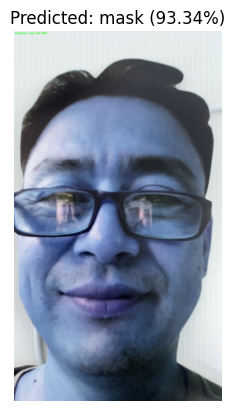

In [37]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
infer_model = WrapperModel.load_from_checkpoint('checkpoint/best.ckpt').to('cuda' if torch.cuda.is_available() else 'cpu')
def predict_image(img, model: WrapperModel):
    model.eval()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (300, 300))
    img = EfficientNet_B3_Weights.IMAGENET1K_V1.transforms()(Image.fromarray(img)).unsqueeze(0).to(model.device)
    with torch.no_grad():
        outputs = model(img)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, dim=1)
    # return img_classes[pred.item()], conf.item()
    return pred.item(), conf.item()

img_path = '/kaggle/working/data/cutout/104.MOV_0.jpg'
img = cv2.imread(img_path)
label, confidence = predict_image(img=img, model=infer_model)
cv2.putText(img, f'Predicted: {img_classes[label]} ({confidence*100:.2f}%)', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Hiển thị ảnh bằng matplotlib
cvt_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cvt_img)
plt.title(f'Predicted: {img_classes[label]} ({confidence*100:.2f}%)')
plt.axis('off')
plt.show()

In [42]:
def create_submission_csv(test_folder: str, model: WrapperModel, output_csv: str):
    results = []
    df = pd.read_csv("/kaggle/input/haui-aio/metadata/metadata/publics_test_metadata.csv")
    test_files = df['path'].tolist()
    for file in tqdm(test_files, desc="Predicting"):
        file_path = os.path.join(test_folder, os.path.basename(file))
        best = 0.0
        best_label = None
        if file_path.lower().endswith(('.mp4', '.mov', '.avi', '.mkv')):
            # Lấy 5 frame từ video, dựa trên tỉ lệ phần trăm (0.2, 0.4, 0.6, 0.8) sau đó lấy dự đoán trung bình
            for ele in [0.2, 0.4, 0.6, 0.8]:
                cap = cv2.VideoCapture(file_path)
                if not cap.isOpened():
                    continue
                total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                cap.set(cv2.CAP_PROP_POS_FRAMES, int(total_frame * ele))
                flag, frame = cap.read()
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                if not flag:
                    continue
                label, confidence = predict_image(frame, model)
                if confidence > best:
                    best = confidence
                    best_label = label
            results.append({
                'file': os.path.basename(file),
                'label': best_label,
                'confidence': best
            })
        elif file_path.lower().endswith(('.jpg', '.jpeg', '.png')):
            img = cv2.imread(file_path)
            label, confidence = predict_image(img, model)
            results.append({
                'file': os.path.basename(file),
                'label': label,
                'confidence': confidence
            })
            # cap = cv2.VideoCapture(file_path)
            # if not cap.isOpened():
            #     continue
            # total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            # cap.set(cv2.CAP_PROP_POS_FRAMES, total_frame // 2)
            # flag, frame = cap.read()
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # if not flag:
            #     continue
            # label, confidence = predict_image(frame, model)
            # results.append({
            #     'file': os.path.basename(file),
            #     'label': label,
            #     'confidence': confidence
            # })
    df['label_pred'] = [res['label'] for res in results]
    df['confidence'] = [res['confidence'] for res in results]

    df.to_csv(output_csv, index=False)

In [43]:
create_submission_csv(
    test_folder='/kaggle/input/haui-aio/publics_data_test/data_test', 
    model=infer_model, 
    output_csv='submission.csv'
)

Predicting:   0%|          | 0/170 [00:00<?, ?it/s]

In [47]:
df_read = pd.read_csv('submission.csv')
df_read['label_pred_translated'] = df_read['label_pred'].apply(lambda x: img_classes[x])

In [48]:
df_read

,path,uuid,label_pred,confidence,label_pred_translated
0,16.mp4,1dee7310-207a-419c-ae58-487e72e066ac,5,0.939302,mask3d
1,30.mp4,6f9a1ca2-749c-4af2-bdd3-31a1b13ca980,3,0.999982,live
2,4.mp4,77e7b685-95e8-4e44-8d49-8558aa0fbb78,3,0.999539,live
3,real_1.mp4,ef74552f-7f40-4abf-8db7-922a8e85ad08,3,0.999865,live
4,real_10.mp4,58b4974b-0cb8-4c66-ab34-554c214c2573,3,0.999158,live
...,...,...,...,...,...
165,48.MOV,f185751f-563a-465b-85d9-b9c0e2b1ba97,1,0.989578,Print_Attacks_Samples
166,56.MOV,3bd00c36-0da4-4d67-a55b-201bba3f4e1c,5,0.999912,mask3d
167,58.MOV,5382f2bb-bc47-4443-9fbe-aa3227ed68bc,1,0.935298,Print_Attacks_Samples
168,61.MOV,3a074a9e-5039-4f18-b1b5-2232f5f33108,1,0.955171,Print_Attacks_Samples
